<a href="https://colab.research.google.com/github/viratchowdary21/speech-recognization/blob/main/speech_representation_and_data_exploration_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Table of contents:

* [1. Visualization of the recordings - input features](#visualization)
   * [1.1. Wave and spectrogram](#waveandspectrogram)
   * [1.2. MFCC](#mfcc)
   * [1.3. Sprectrogram in 3d](#3d)
   * [1.4. Silence removal](#resampl)
   * [1.5. Resampling - dimensionality reductions](#silenceremoval)
   * [1.6. Features extraction steps](#featuresextractionsteps)
* [2. Dataset investigation](#investigations)
   * [2.1. Number of files](#numberoffiles)
   * [2.2. Mean spectrograms and fft](#meanspectrogramsandfft)
   * [2.3. Deeper into recordings](#deeper)
   * [2.4. Length of recordings](#len)
   * [2.5. Note on Gaussian Mixtures modeling](#gmms)
   * [2.6. Frequency components across the words](#components)
* [3. CNN/RNN - CTC(loss func)-Models](#Model Building)

All we need is here:

In [ ]:
import tensorflow as tf
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


2021-11-15 09:13:09.492883: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-11-15 09:13:09.492930: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: soet-gpu1
2021-11-15 09:13:09.492935: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: soet-gpu1
2021-11-15 09:13:09.493040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.82.0
2021-11-15 09:13:09.493059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2021-11-15 09:13:09.493063: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.57.2 does not match DSO version 470.82.0 -- cannot find working devices in this configuration


In [ ]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline


# 1. Visualization 
<a id="visualization"></a> 

There are two theories of a human hearing - place ( https://en.wikipedia.org/wiki/Place_theory_(hearing) (frequency-based) and temporal (https://en.wikipedia.org/wiki/Temporal_theory_(hearing) )
In speech recognition, I see two main tendencies - to input [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

Let's visualize some recordings!

## 1.1. Wave and spectrogram:
<a id="waveandspectrogram"></a> 

Choose and read some file:

In [ ]:
import os
datapath = 'train/audio/'
datapath1 = 'test/'
sub_folder = os.listdir(datapath)

In [ ]:
files = []
sub_path = str(datapath) + sub_folder[0] + '/'
for i in os.listdir(sub_path):
        files.append(i)

In [ ]:
print("the number of audio samples that exist for each word are...")
for i in sub_folder:
    print(i + " : " + str(len(os.listdir(str(datapath)+str(i)+'/'))))


the number of audio samples that exist for each word are...
right : 2367
seven : 2377
sheila : 1734
one : 2370
go : 2372
wow : 206
zero : 540
on : 2367
bird : 1731
house : 1750
tree : 1733
up : 275
off : 2357
dog : 1746
bed : 1713
no : 2375
five : 2357
six : 2369
two : 2107
eight : 2352
nine : 2364
yes : 287
marvin : 1746
stop : 2380
happy : 1742
left : 2353
down : 2359
cat : 1733
four : 2372
three : 2356


In [ ]:
sub_path+files[0]

'train/audio/right/9a7c1f83_nohash_5.wav'

In [ ]:
# train_audio_path = 'speech_rec/train/train/train/audio'
filename = sub_path+files[0]

import scipy.io.wavfile
sample_rate, samples = scipy.io.wavfile.read('train/audio/five/0132a06d_nohash_0.wav')


In [ ]:
sample_rate_test, samples_test = scipy.io.wavfile.read('test/clip_0000adecb.wav')

In [ ]:
len(samples_test)

16000

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear.
We need to assure that there are no 0 values as input to logarithm.

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Frequencies are in range (0, 8000) according to [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate).

Let's plot it:

Text(0.5, 0, 'Seconds')

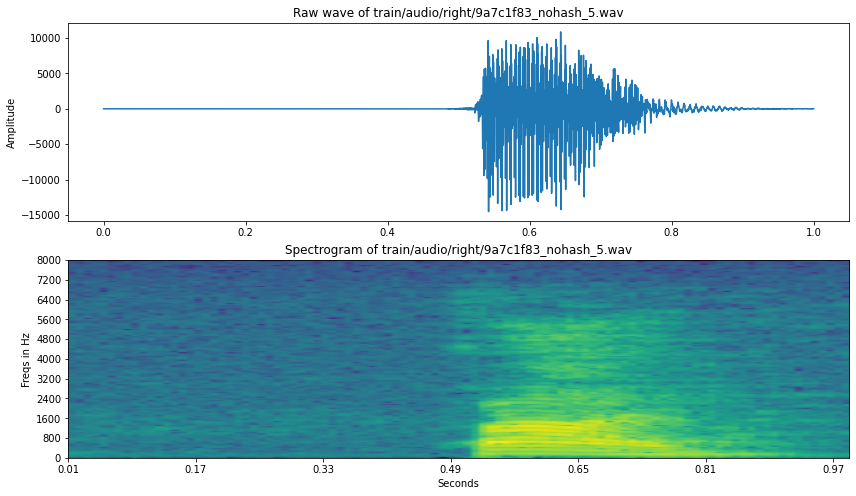

In [ ]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

If we use spectrogram as an input features for NN, we have to remember to normalize features. (We need to normalize over all the dataset, here's example just for one, which doesn't give good *mean* and *std*!)

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

There is an interesting fact to point out. We have ~160 features for each frame, frequencies are between 0 and 8000. It means, that one feature corresponds to 50 Hz. However, [frequency resolution of the ear is 3.6 Hz within the octave of 1000 – 2000 Hz](https://en.wikipedia.org/wiki/Psychoacoustics) It means, that people are far more precise and can hear much smaller details than those represented by spectrograms like above.

## 1.2. MFCC
<a id="mfcc"></a> 

If you want to get to know some details about *MFCC* take a look at this great tutorial. [MFCC explained](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) You can see, that it is well prepared to imitate human hearing properties.

You can calculate *Mel power spectrogram* and *MFCC* using for example *librosa* python package.


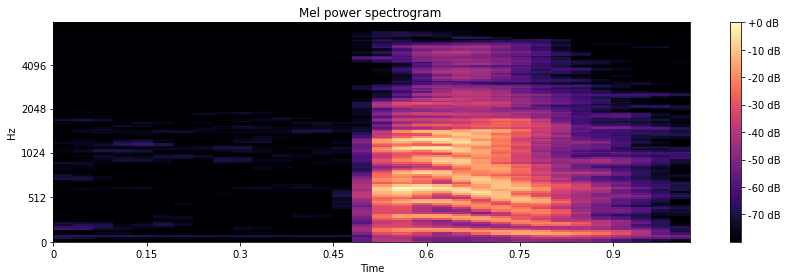

In [ ]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples.astype('float16'), sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

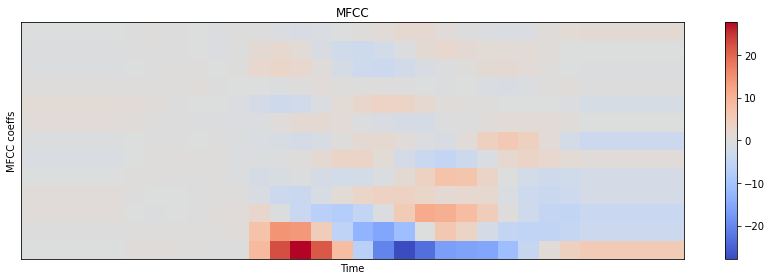

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, *MFCC*  or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example *MFCC* decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.a

It is your decision which to choose!

## 1.3. Spectrogram in 3d
<a id="3d"></a> 

By the way, times change, and the tools change. Have you ever seen spectrogram in 3d?

In [ ]:
type(spectrogram)

numpy.ndarray

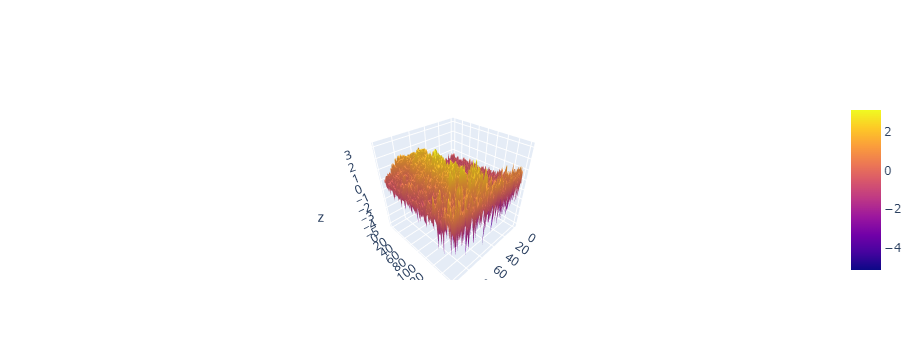

In [ ]:
data = [go.Surface(z=spectrogram.T)]
fig = go.Figure(data=data) # , layout=layout)
py.iplot(fig)

(Don't know how to set axis ranges to proper values yet. I'd also like it to be streched like a classic spectrogram above..)

## 1.4. Silence removal
<a id="silenceremoval"></a> 

Let's listen to that file

In [ ]:
ipd.Audio(samples, rate=sample_rate)

I consider that some *VAD* (Voice Activity Detection) will be really useful here. Although the words are short, there is a lot of silence in them. A decent *VAD* can reduce training size a lot, accelerating training speed significantly.
Let's cut a bit of the file from the beginning and from the end. and listen to it again (based on a plot above, we take from 4000 to 13000):

In [ ]:
samples_cut = samples[4000:13000]
# samples_cut = samples

ipd.Audio(samples_cut, rate=sample_rate)

We can agree that the entire word can be heard. It is impossible to cut all the files manually and do this basing on the simple plot. But you can use for example *webrtcvad* package to have a good *VAD*.

Let's plot it again, together with guessed alignment of* 'y' 'e' 's'* graphems

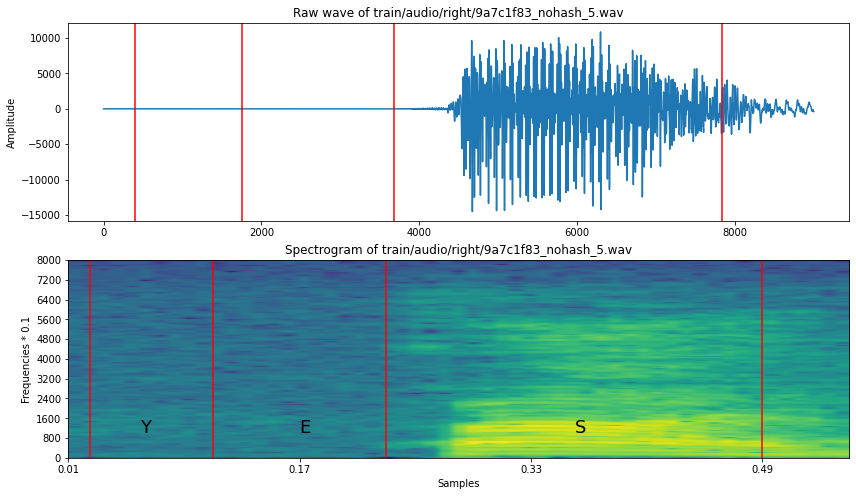

In [ ]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.5. Resampling - dimensionality reduction
<a id="resampl"></a> 

Another way to reduce the dimensionality of our data is to resample recordings.

You can hear that the recording don't sound very natural, because they are sampled with 16k frequency, and we usually hear much more. However, [the most speech related frequencies are presented in smaller band](https://en.wikipedia.org/wiki/Voice_frequency). That's why you can still understand another person talking to the telephone, where GSM signal is sampled to 8000 Hz.

Summarizing, we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.

We have to remember that it can be risky, because this is a competition, and sometimes very small difference in performance wins, so we don't want to lost anything. On the other hand, first experiments can be done much faster with smaller training size.

We'll need to calculate FFT (Fast Fourier Transform). Definition:


In [ ]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

Let's read some recording, resample it, and listen. We can also compare FFT, Notice, that there is almost no information above 4000 Hz in original signal.

In [ ]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(datapath) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

In [ ]:
ipd.Audio(samples, rate=sample_rate)

In [ ]:
ipd.Audio(resampled, rate=new_sample_rate)

Almost no difference!

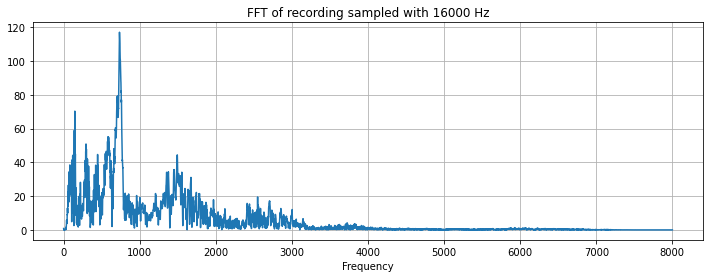

In [ ]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

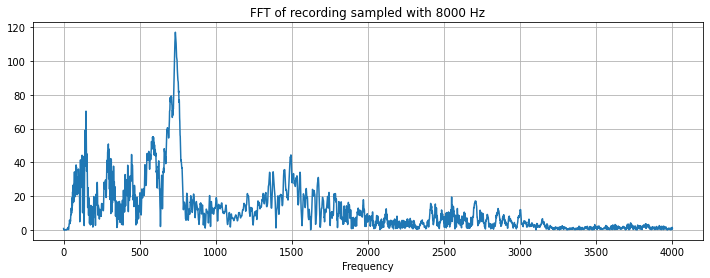

In [ ]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

This is how we reduced dataset size twice!

## 1.6. Features extraction steps
<a id="featuresextractionsteps"></a> 

I would propose the feature extraction algorithm like that:
1. Resampling
2. *VAD*
3. Maybe padding with 0 to make signals be equal length
4. Log spectrogram (or *MFCC*, or *PLP*)
5. Features normalization with *mean* and *std*
6. Stacking of a given number of frames to get temporal information

It's a pity it can't be done in notebook. It has not much sense to write things from zero, and everything is ready to take, but in packages, that can not be imported in Kernels.


# 2. Dataset investigation
<a id="investigations"></a> 

Some usuall investgation of dataset.

## 2.1. Number of records
<a id="numberoffiles"></a> 


In [ ]:
dirs = [f for f in os.listdir(datapath) if isdir(join(datapath, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 30


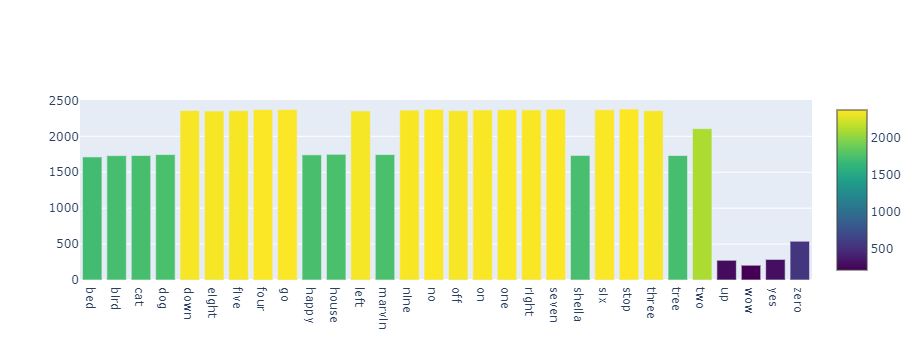

In [ ]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(datapath, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridis', showscale=True
    ),
)
# layout = go.Layout(
#     title='Number of recordings in given label',
#     xaxis = dict(title='Words'),
#     yaxis = dict(title='Number of recordings')
# )
py.iplot(go.Figure(data=[trace])) # , layout=layout))


Dataset is balanced except of background_noise, but that's the different thing.

## 2.2. Deeper into recordings
<a id="deeper"></a> 

There's a very important fact. Recordings come from very different sources. As far as I can tell, some of them can come from mobile GSM channel.

Nevertheless,** it is extremely important to split the dataset in a way that one speaker doesn't occur in both train and test sets.**
Just take a look and listen to this two examlpes:

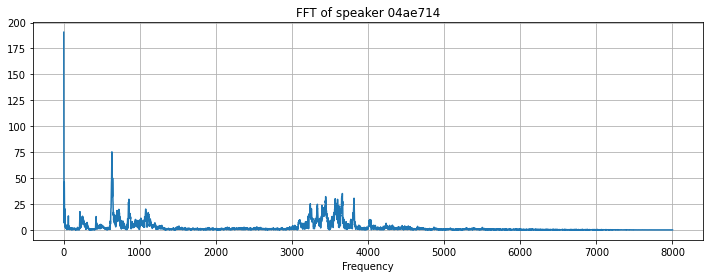

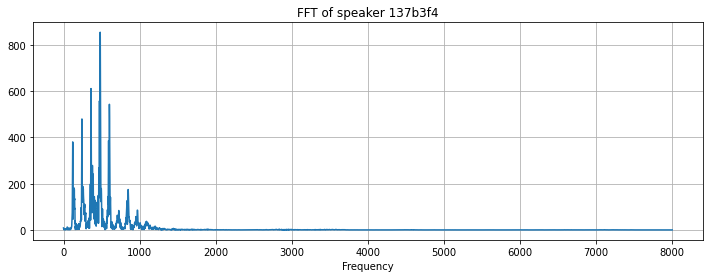

In [ ]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(datapath) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

Even better to listen:

In [ ]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(datapath, filenames[0]))

Speaker 04ae714


In [ ]:
print('Speaker ' + filenames[1][4:11])
ipd.Audio(join(datapath, filenames[1]))

Speaker 137b3f4


There are also recordings with some weird silence (some compression?):


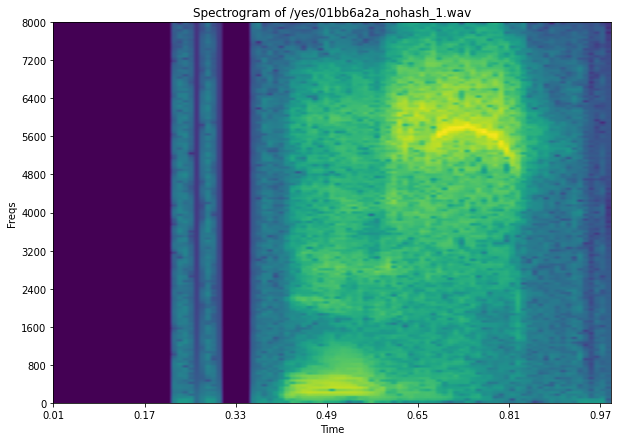

In [ ]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(datapath) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

It means, that we have to prevent overfitting to the very specific acoustical environments.


## 2.3. Recordings length
<a id="len"></a> 

Find if all the files have 1 second duration:

In [ ]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(datapath, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(datapath + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

Number of recordings shorter than 1 second: 5628


/tmp/ipykernel_412931/504030349.py:5: WavFileWarning:

Reached EOF prematurely; finished at 16384 bytes, expected 32044 bytes from header.



That's suprising, and there is a lot of them. We can pad them with zeros.

## 2.4. Mean spectrograms and FFT
<a id="meanspectrogramsandfft"></a> 

Let's plot mean FFT for every word

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


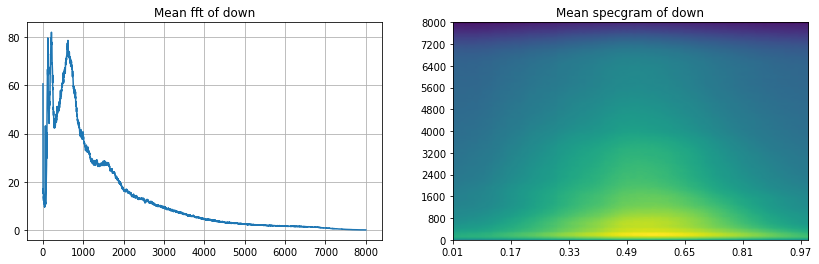

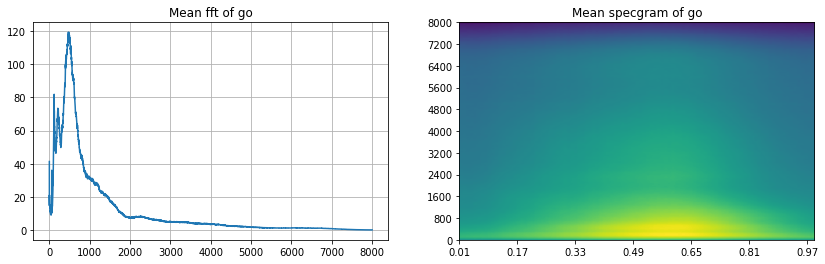

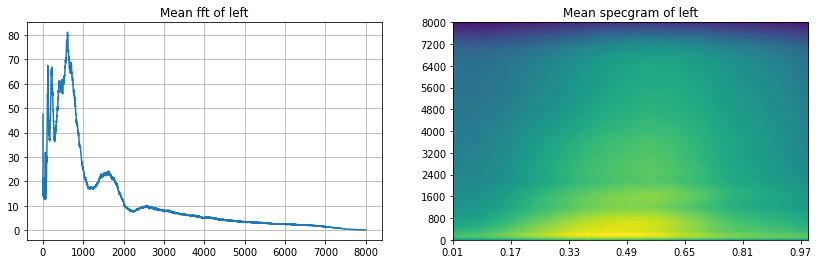

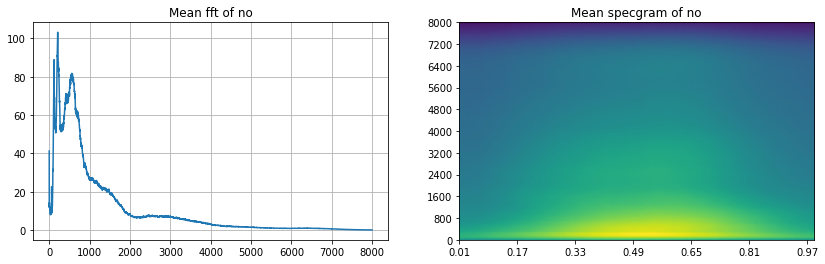

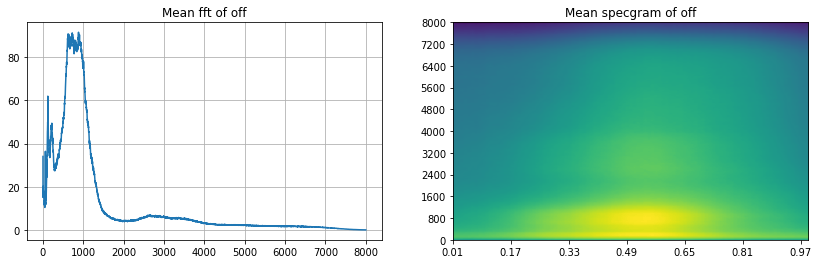

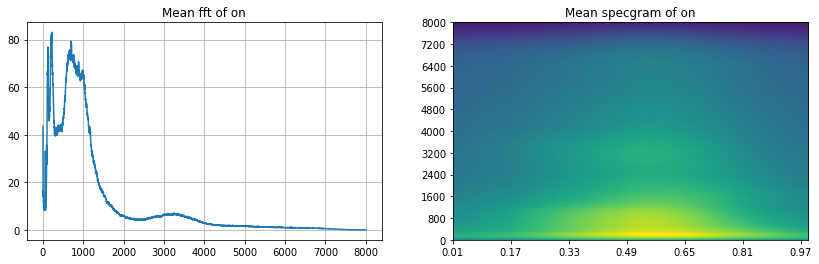

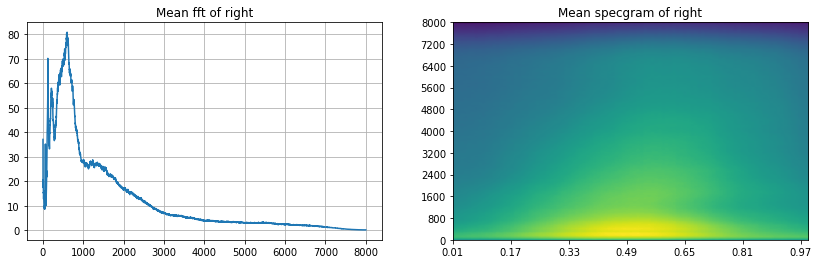

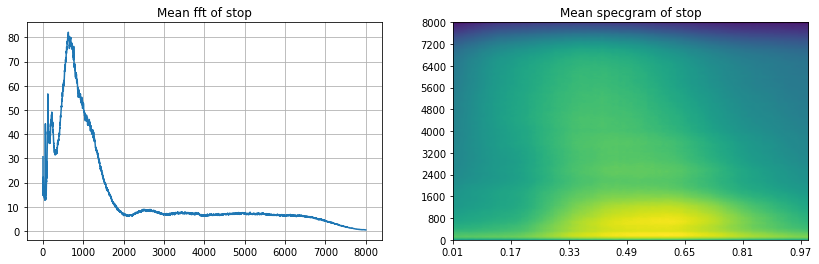

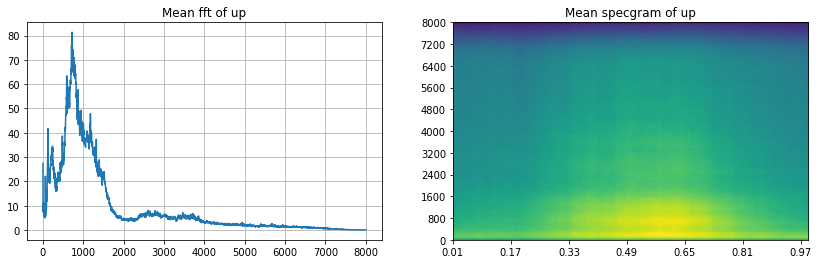

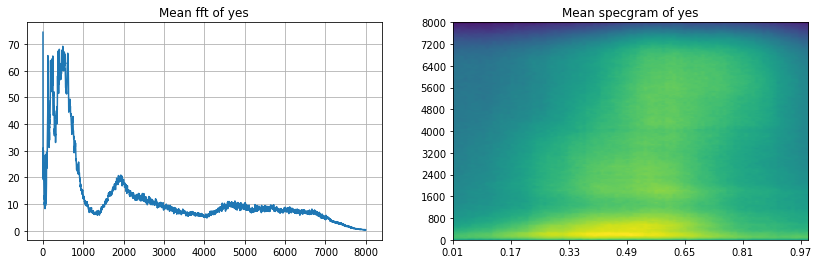

In [ ]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(datapath, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(datapath + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

## 2.5. Gaussian Mixtures modeling
<a id="gmms"></a> 

We can see that mean FFT looks different for every word. We could model each FFT with a mixture of Gaussian distributions. Some of them however, look almost identical on FFT, like *stop* and *up*... But wait, they are still distinguishable when we look at spectrograms! High frequencies are earlier than low at the beginning of *stop* (probably *s*).

That's why temporal component is also necessary. There is a [Kaldi](http://kaldi-asr.org/) library, that can model words (or smaller parts of words) with GMMs and model temporal dependencies with [Hidden Markov Models](https://github.com/danijel3/ASRDemos/blob/master/notebooks/HMM_FST.ipynb).

We could use simple GMMs for words to check what can we model and how hard it is to distinguish the words. We can use [Scikit-learn](http://scikit-learn.org/) for that, however it is not straightforward and lasts very long here, so I abandon this idea for now.

## 2.6. Frequency components across the words
<a id="components"></a> 


In [ ]:
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(datapath, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                datapath + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

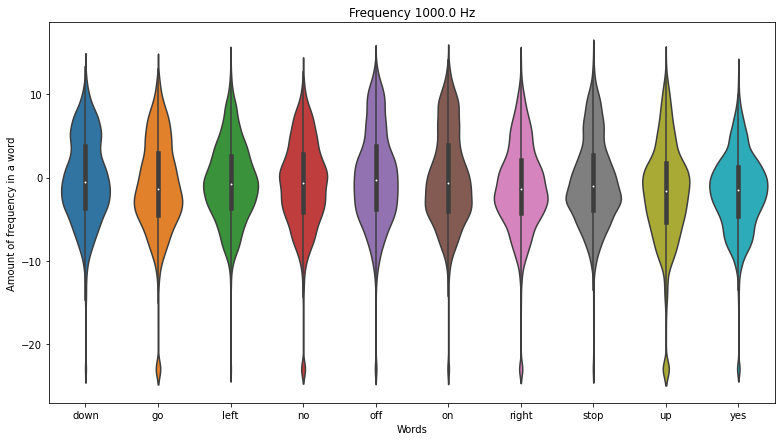

In [ ]:
violinplot_frequency(dirs, 20)

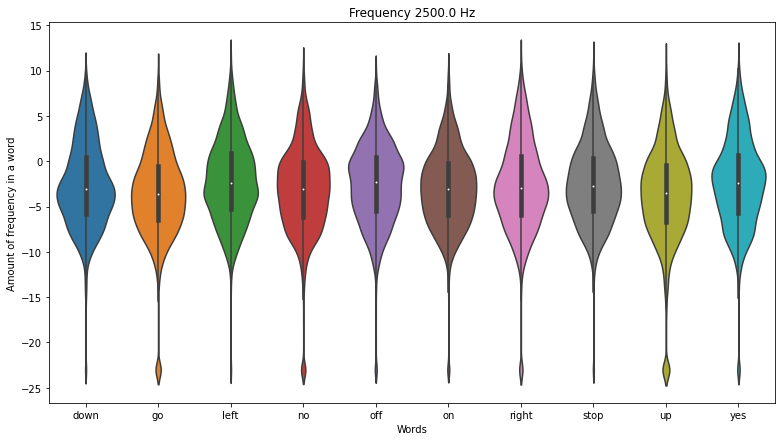

In [ ]:
violinplot_frequency(dirs, 50)

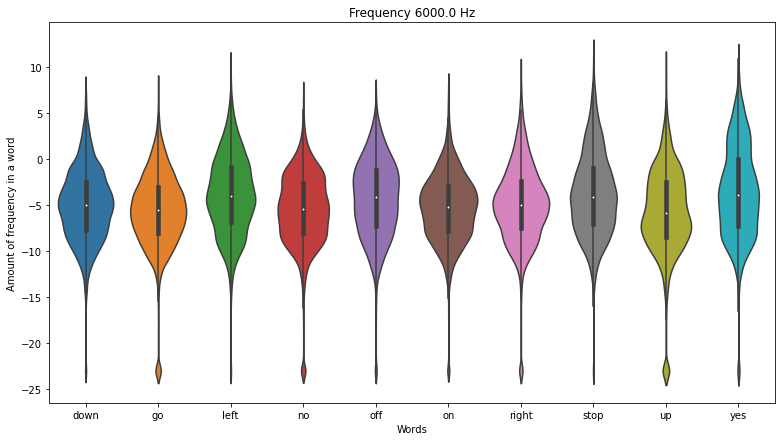

In [ ]:
violinplot_frequency(dirs, 120)

Notice that there are *yes/e4b02540_nohash_0.wav*, *go/0487ba9b_nohash_0.wav* and more points, that lie far away from the rest. Let's listen to them.

In [ ]:
print('Recording go/0487ba9b_nohash_0.wav')
ipd.Audio(join(datapath, 'go/0487ba9b_nohash_0.wav'))

Recording go/0487ba9b_nohash_0.wav


If you will look for anomalies for individual words, you can find for example this file for *seven*:

In [ ]:
print('Recording seven/e4b02540_nohash_0.wav')
ipd.Audio(join(datapath, 'seven/b1114e4f_nohash_0.wav'))

Recording seven/e4b02540_nohash_0.wav


That's nothing obviously important. Usually you can find some distortions using this method. Data seems to contain what it should.

In [ ]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"] # i used limited data due to lack of computation power

all_wave = []
all_label = []
all_label_spec = []

all_wave_spec = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(datapath + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(datapath + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        zero_padding = tf.zeros([8000] - tf.shape(samples), dtype=tf.float32)
        samples = tf.cast(samples, tf.float32)
        equal_length = tf.concat([samples, zero_padding], 0)
        spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)

        spectrogram = tf.abs(spectrogram)
        
        all_wave_spec.append(spectrogram)
        all_label_spec.append(label)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes


2021-11-15 09:13:28.096087: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


no
up
down
left
right
on
off
stop
go


In [ ]:
ipd.Audio(all_wave[800], rate=8000)

In [ ]:
all_label[800]

'no'

In [ ]:
len(all_label), len(all_label_spec)

(17594, 19492)

In [ ]:
len(all_wave), len(all_wave_spec)

(17594, 19492)

In [ ]:
test_set = []
test = [f for f in os.listdir(datapath1) if f.endswith('.wav')]
for wav in test:
    samples, sample_rate = librosa.load(datapath1 + wav, sr = 16000)
    samples = librosa.resample(samples, sample_rate, 8000)
    if(len(samples)== 8000) : 
        test_set.append(samples)


In [ ]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)


In [ ]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))


In [ ]:
all_wave = np.array(all_wave).reshape(-1,8000,1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)
X_test = np.array(test_set) 

In [ ]:
X_train.shape

(14075, 8000, 1)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.2)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.2)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)           0     

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.00001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [ ]:
history=model.fit(X_train, y_train ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(X_val,y_val))
# validation_dataset
# train_dataset
# history=model.fit(train_dataset,epochs=1, callbacks=[es,mc], batch_size=32, validation_data=(validation_dataset))


2021-11-15 09:17:23.017145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
440/440 [==============================] - 11s 23ms/step - loss: 2.2195 - accuracy: 0.1206 - val_loss: 2.1864 - val_accuracy: 0.1199
Epoch 2/100
440/440 [==============================] - 10s 23ms/step - loss: 2.1779 - accuracy: 0.1298 - val_loss: 2.1782 - val_accuracy: 0.1375
Epoch 3/100
440/440 [==============================] - 10s 24ms/step - loss: 2.1712 - accuracy: 0.1310 - val_loss: 2.1671 - val_accuracy: 0.1623
Epoch 4/100
440/440 [==============================] - 10s 23ms/step - loss: 2.1627 - accuracy: 0.1403 - val_loss: 2.1590 - val_accuracy: 0.1674
Epoch 5/100
440/440 [==============================] - 10s 24ms/step - loss: 2.1549 - accuracy: 0.1521 - val_loss: 2.1473 - val_accuracy: 0.1762
Epoch 6/100
440/440 [==============================] - 10s 23ms/step - loss: 2.1403 - accuracy: 0.1691 - val_loss: 2.1246 - val_accuracy: 0.1969
Epoch 7/100
440/440 [==============================] - 10s 23ms/step - loss: 2.1160 - accuracy: 0.1887 - val_loss: 2.0931 - val_ac

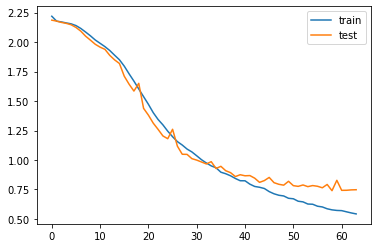

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [ ]:
X_val.shape

(3519, 8000, 1)

In [ ]:
# model.load_weights('best_model.hdf5')
model.evaluate(X_val, y_val, verbose=1)

110/110 [==============================] - 1s 5ms/step - loss: 0.7474 - accuracy: 0.7587


[0.7474256753921509, 0.7587382793426514]

In [ ]:
prob=model.predict(X_val)


In [ ]:
prob.shape

(3519, 10)

In [ ]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    print(prob.shape)
    index=np.argmax(prob[0])
    # print(CTCLoss(audio, prob))
    
    return classes[index]

In [ ]:
import random
index=random.randint(0,len(X_val)-1)
samples=X_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: go
(1, 10)
Text: no


In [ ]:
import random
index=random.randint(0,len(X_test)-1)
test_samples=X_test[index].ravel()
# print("Audio:",classes[np.argmax(y_val[index])])
print("predicted Text:",predict(test_samples))

(1, 10)
predicted Text: right


In [ ]:
ipd.Audio(test_samples, rate=8000)

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [ ]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_spec=le.fit_transform(all_label_spec)
classes= list(le.classes_)

from keras.utils import np_utils
y_spec=np_utils.to_categorical(y_spec, num_classes=len(labels))


# rnn-ctc loss

In [ ]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(np.array(all_wave_spec),np.array(y_spec),stratify=all_label_spec,test_size = 0.2,random_state=77,shuffle=True)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Reshape, Activation, Flatten

In [ ]:
input_data = Input(shape=(61, 129, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), strides=(2,2),padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), strides=(2,2), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((32, 64)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(128, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(64, return_sequences=True), name = 'lstm2')(inner)
inner = Flatten()(inner)
## OUTPUT
inner = Dense(256, activation='relu', kernel_initializer='he_normal',name='dense2')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal',name='dense3')(inner)

inner = Dense(10, kernel_initializer='he_normal',name='dense4')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model_crnn = Model(inputs=input_data, outputs=y_pred)
model_crnn.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 61, 129, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 61, 129, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 61, 129, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 61, 129, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 30, 64, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 15, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 32, 64)        256 

In [ ]:
model_crnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])


In [ ]:
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape

((15593, 61, 129), (15593, 10), (3899, 61, 129), (3899, 10))

In [ ]:
mc1 = ModelCheckpoint('best_model_crnn.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history1 = model_crnn.fit(X_train1, y_train1, epochs=20, callbacks=[es, mc1], batch_size=8, 
                    validation_data=(X_val1, y_val1), shuffle=False)


Epoch 1/20
1950/1950 [==============================] - 92s 46ms/step - loss: 1.6715 - acc: 0.3782 - val_loss: 1.0692 - val_acc: 0.6427

Epoch 00001: val_acc improved from -inf to 0.64273, saving model to best_model_crnn.hdf5
Epoch 2/20
1843/1950 [===========================>..] - ETA: 4s - loss: 0.8867 - acc: 0.6924

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history1.history['acc'], label='train') 
pyplot.plot(history1.history['val_acc'], label='test') 
pyplot.legend()
pyplot.show()

# both are almost same but using less no.of epochs seems to be overftting

In [ ]:
# model_crnn.load_weights('best_model_crnn.hdf5')
model_crnn.evaluate(X_val1, y_val1, verbose=1)

In [ ]:
def predict_crnn(audio):
    prob=model_crnn.predict(audio.reshape(-1, 61, 129, 1))
    print(prob.shape)
    index=np.argmax(prob[0])
    # print(CTCLoss(audio, prob))
    
    return classes[index]

In [ ]:
test_list = []
waves = [f for f in os.listdir('test/') if f.endswith('.wav')]
for wav in waves:
    samples, sample_rate = librosa.load('test/' + wav, sr = 16000)
    samples = librosa.resample(samples, sample_rate, 8000)
    zero_padding = tf.zeros([8000] - tf.shape(samples), dtype=tf.float32)
    samples = tf.cast(samples, tf.float32)
    equal_length = tf.concat([samples, zero_padding], 0)
    test_spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)

    test_spectrogram = tf.abs(test_spectrogram)

    test_list.append(test_spectrogram)


In [ ]:
len(test_list)

In [ ]:
test_list[0].shape

In [ ]:
X_test1 = np.array(test_list)

In [ ]:
import random
index1=random.randint(0,len(X_test1)-1)
test_samples1=X_test1[index1].ravel()
print("predicted Text:",predict_crnn(test_samples1))

In [ ]:
ipd.Audio(test_samples1, rate=8000)

## CTC Loss: 


In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    # print(y_true, y_pred)
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    # print('1', input_length, label_length)

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    # print('2', input_length, label_length)

    loss = tf.nn.ctc_loss(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
history = model_crnn.fit(X_train1, y_train1, epochs=100, callbacks=[es], batch_size=8, 
                    validation_data=(X_val1, y_val1), shuffle=False)

